In [1]:
# # Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

# Imports

In [2]:
import time
import sys
import random
import pickle
import operator
from itertools import product
from joblib import Parallel, delayed, parallel_backend
from collections import defaultdict

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_random,
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
)

In [4]:
n_jobs = 4 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]

# Functions

In [5]:
def numpy_array_to_iris_df(numpy_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    mask = [np.ones(DIM[1:], dtype=np.bool_) for _ in range(DIM[0])]
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(matrix), mask) for matrix in numpy_array)
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [6]:
def import_voter_model_rust_implementation(path_low, path_high, total_num_samples, num_samples=None):
    num_samples = num_samples if num_samples else total_num_samples
    assert num_samples <= total_num_samples
    low_high_data_lst = [
        np.unpackbits(np.fromfile(path, dtype=np.uint8), bitorder="little")
        .reshape(total_num_samples, X, Y)
        [np.random.choice(total_num_samples, size=num_samples, replace=False)] for path in [path_low, path_high]
    ]
    data = np.stack(low_high_data_lst, axis=1).astype(bool)
    return numpy_array_to_iris_df(data)

In [7]:
def load_synthetic_iris(method, num_samples, path='compressed_iris_matrices'):
    # Load data and randomly select num_samples samples
    loaded_data = np.load(f'{path}_{method}.npz')['data']
    assert loaded_data.shape[0] >= num_samples, f"Requested {num_samples} samples, but only {loaded_data.shape[0]} available."
    indices = np.random.choice(loaded_data.shape[0], num_samples, replace=False)
    return numpy_array_to_iris_df(loaded_data[indices].reshape(num_samples, *DIM))

In [8]:
def update_db(db, iris_df, db_size):
    db_current_size = db.get_stats()['db_size']
    assert (db_size - db_current_size) > 0
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for iris in new_irises:
        db.insert(make_query(iris))
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [9]:
midpoints = np.load('noise_distribution_bin_midpoints.npz')['data']
probabilities = np.load('noise_distribution_probability_distribution.npz')['data']
def sample_noise(midpoints=midpoints, probabilities=probabilities, sample_size=1):
    return np.random.choice(midpoints, size=sample_size, p=probabilities)

In [10]:
def run_single_experiment(i, db, idx, iris, noise, efSearch, K):
    # np.random.seed(i), random.seed(i)
    # iris, random_target_id = iris_df[iris_df['ID'].notna()].sample(1).iloc[0]
    noisy_query = make_query(iris_with_noise(iris, noise_level=noise))
    res = db.search(noisy_query, K, ef=efSearch)
    return next((i for i, (_, num) in enumerate(res) if num == idx), np.inf)

In [11]:
def process_stats(db):
    temp = db.get_stats()['code_run_stats']
    proportions_dict = defaultdict(list)
    for layer, values_list in temp:
        proportions_dict[layer].append(values_list)
    return {layer: pd.DataFrame(data) for layer, data in proportions_dict.items()}

In [12]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

# Configurations

## Param combinations

In [13]:
# Constants values
num_experiments = 100
precision_thres = 0.99
K = 200

In [14]:
num_db_elements = np.arange(1000, 10001, 1000)
Ms = np.arange(10, 101, 10)
efConstructions = np.arange(50, 501, 50)
efSearchs = np.arange(50, 501, 50)
parameter_combinations = sorted(list(product(Ms, efConstructions, efSearchs)))

# Output the total number of combinations for verification
print(f"Total parameter combinations: {len(parameter_combinations)*len(num_db_elements)}")

Total parameter combinations: 10000


## Multi-Notebooking

In [15]:
NOTEBOOK_NUM = 1

In [16]:
# threading_path = 'threading_df.parquet'
# threading_df = pd.DataFrame(parameter_combinations, columns=['M', 'efConstruction', 'efSearch']).assign(status = 'Not Started')
# threading_df.to_parquet(threading_path)

In [17]:
def multinotebook_threading_combination_pull(threading_path='threading_df.parquet'):
    threading_df = pd.read_parquet(threading_path)
    next_combination = threading_df[threading_df['status'] == 'Not Started'].sample(n=1)        
    index, (M, efConstruction, efSearch, status) = *next_combination.index, *next_combination.values
    threading_df.loc[index, 'status'] = 'Pending'
    threading_df.to_parquet(threading_path)
    return index, (threading_df['status'] != 'Not Started').mean(), M, efConstruction, efSearch

In [18]:
def multinotebook_threading_combination_update(index, total_time, threading_path='threading_df.parquet'):
    threading_df = pd.read_parquet(threading_path)
    threading_df.loc[index, 'status'] = f'Completed in {total_time // 60} minutes'
    threading_df.to_parquet(threading_path)
    return (threading_df['status'] == 'Not Started').any()

# Stats computation

In [25]:
iris_df = import_voter_model_rust_implementation(
    path_low='data/synthetic_iris_data/2M_voter_arrays_80k_b45.dat', 
    path_high='data/synthetic_iris_data/2M_voter_arrays_7k_b13.dat', 
    total_num_samples=1000000, 
    num_samples=num_db_elements.max()
)

In [27]:
results_df_path = f"stats_df{NOTEBOOK_NUM}.parquet"
num_db_elements = np.arange(9000, 10001, 1000)
# stats_df = pd.read_parquet(f"stats_df{NOTEBOOK_NUM}.parquet")
# stats_df = pd.DataFrame(columns=['db_size', 'K', 'M', 'efConstruction', 'efSearch', 'results', 'num_experiments'])
more_left = True

while more_left:
    # Initiate HNSW instance
    start_time = time.time()
    index, ratio, M, efConstruction, efSearch = multinotebook_threading_combination_pull()
    db = hnsw.HNSW(
        M=M, 
        efConstruction=efConstruction, 
        m_L=1/np.log(M), 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    iris_df['Inserted'] = False

    for i, db_size in enumerate(num_db_elements):
        sys.stdout.write(f"\rCurrent progress out of {len(parameter_combinations)} parameter combinations (with {num_experiments} experiments each): {ratio:.1%}, current db_size - {db_size}")
        sys.stdout.flush()

        # Update db using insertions
        update_db(db, iris_df, db_size)

        # Run num_experiments in parallel
        indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values
        noises = sample_noise(sample_size=num_experiments)
        with parallel_backend('threading'):
            results = Parallel(n_jobs=n_jobs)(
                delayed(run_single_experiment)(i, db, indices[i], irises[i], noises[i], efSearch, K) for i in range(num_experiments)
            )

        # Update results
        results = [db_size, K, M, efConstruction, efSearch, results, num_experiments]
        results_df = pd.DataFrame([results], columns=['db_size', 'K', 'M', 'efConstruction', 'efSearch', 'results', 'num_experiments'])
        stats_df = pd.concat([stats_df, results_df], ignore_index=True)
        stats_df.to_parquet(results_df_path)

    # Update threading_df
    more_left = multinotebook_threading_combination_update(index, time.time() - start_time)
print('\nDone!')

Current progress out of 1000 parameter combinations (with 100 experiments each): 100.0%, current db_size - 10000
Done!


In [139]:
# notebook_threading_count = 6
# stats_df_lst = [pd.read_parquet(f"stats_df{i}.parquet") for i in range(1, notebook_threading_count+1)]
# final_stats_df = pd.concat(stats_df_lst)
# final_stats_df.to_parquet("stats_df.parquet")

# Proportion request - Bryan

In [17]:
db = hnsw.HNSW(
    M=64, 
    efConstruction=128, 
    m_L=1/np.log(64), 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)
update_db(db, iris_df, 10000)

In [20]:
stats = process_stats(db)

In [44]:
layer_0 = stats[0].dropna(axis=0, how='all').loc[1000:]
bins = range(1000, 11000, 1000)
labels = [f"{i}-{i+1000}" for i in range(1000, 10000, 1000)]
layer_0['insertion_range'] = pd.cut(layer_0.index, bins=bins, labels=labels, right=False)
layer_0 = layer_0.reset_index().rename(columns={'index': 'insertion_order'})
layer_0 = pd.melt(layer_0, id_vars=['insertion_order', 'insertion_range'], var_name='vertex', value_name='proportion').dropna()

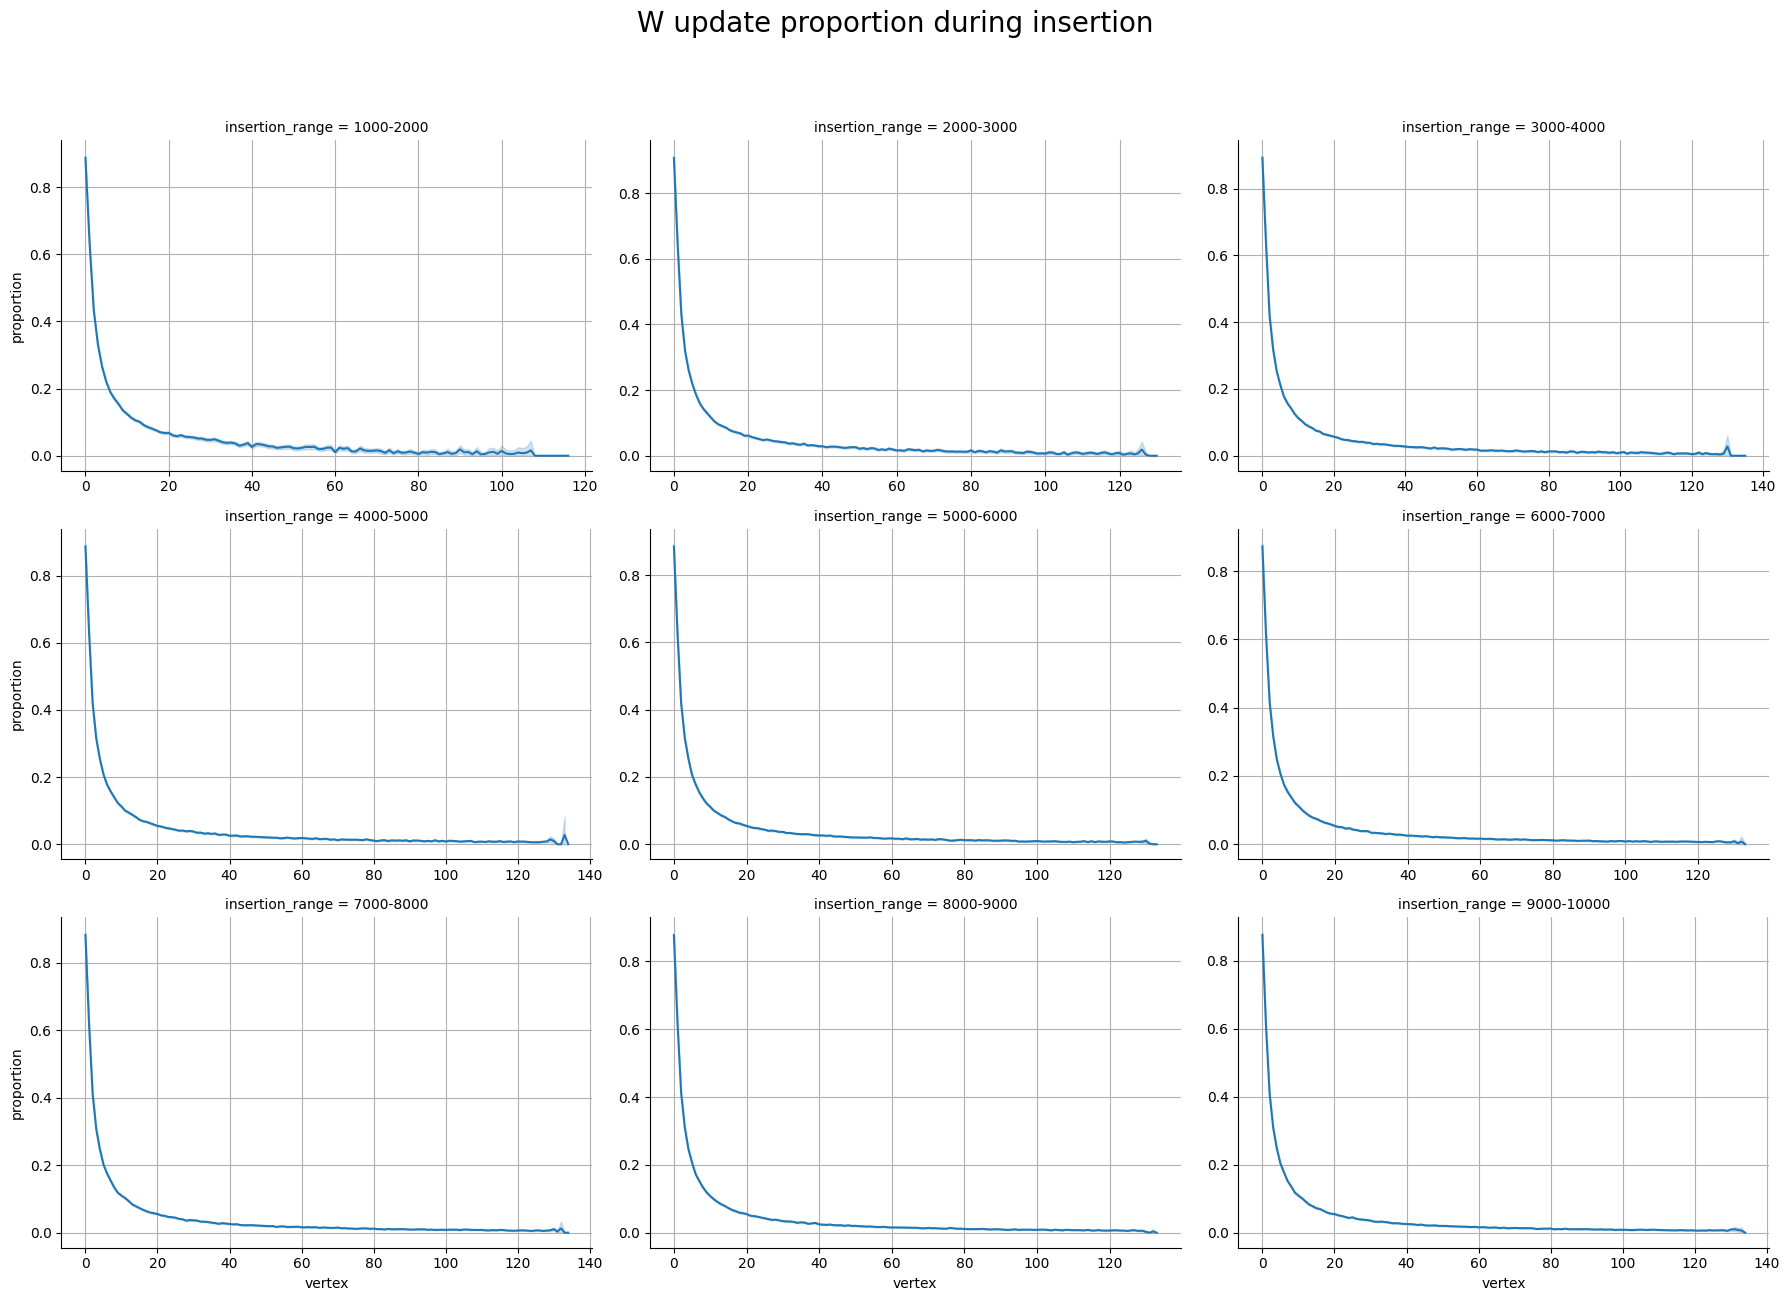

In [59]:
facetgrid = sns.FacetGrid(layer_0, col='insertion_range', col_wrap=3, height=4, aspect=1.5, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x='vertex', y='proportion')
[ax.grid(True) for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle('W update proportion during insertion', fontsize=20, y=1.08)
plt.show()